# Banknote Authentication — Midterm Classification Project
**Author:** Deb St. Cyr  
**Date:** November 11, 2025  

## Introduction
This project predicts whether a banknote is authentic (target: `class`) using four numerical features extracted from wavelet-transformed images: `variance`, `skewness`, `curtosis`, and `entropy`.  
I compare baseline and improved classifiers, quantify performance (accuracy, precision, recall, F1), and visualize results.

**Dataset:** UCI Banknote Authentication (placed locally at `data/banknote_authentication.csv`)

**Repro Steps**
1) `python -m venv .venv && source .venv/Scripts/activate` (Windows) or `source .venv/bin/activate` (macOS/Linux)  
2) `pip install -r requirements.txt`  
3) Open this notebook and run all cells (Kernel → Restart & Run All)


In [1]:
# Section 0. Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Plot defaults
pd.set_option("display.max_columns", 50)
sns.set_theme()


## 1. Import and Inspect the Data

**1.1** Load the dataset and display the first 10 rows.  
**1.2** Check for missing values and display summary statistics.

**Reflection 1.** What do you notice about the dataset? Any data issues?


In [3]:
# 1.1 Load

import pandas as pd

CSV_PATH = "data/banknote_authentication.txt"  # adjust if running from repo root

# Load the dataset
df = pd.read_csv(CSV_PATH, header=None)

# Assign column names (UCI reference)
df.columns = ["variance", "skewness", "curtosis", "entropy", "class"]

print("Encoding check complete (UTF-8 expected).")

# Preview first 5 rows
display(df.head())

# Shape and summary
print(f"Shape: {df.shape}")
print("\nMissing values per column:")
print(df.isna().sum())

# Quick distribution of target classes
print("\nTarget variable counts:")
print(df['class'].value_counts())


Encoding check complete (UTF-8 expected).


,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


Shape: (1372, 5)

Missing values per column:
variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

Target variable counts:
class
0    762
1    610
Name: count, dtype: int64


In [4]:
# 1.2 Missing + summary
display(df.isna().sum())
display(df.describe().T)

# Target distribution quick look
df['class'].value_counts(normalize=True).rename('proportion')


variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

,count,mean,std,min,25%,50%,75%,max
variance,1372.0,0.433735,2.842763,-7.0421,-1.773000,0.49618,2.821475,6.8248
skewness,1372.0,1.922353,5.869047,-13.7731,-1.708200,2.31965,6.814625,12.9516
curtosis,1372.0,1.397627,4.310030,-5.2861,-1.574975,0.61663,3.179250,17.9274
entropy,1372.0,-1.191657,2.101013,-8.5482,-2.413450,-0.58665,0.394810,2.4495
class,1372.0,0.444606,0.497103,0.0000,0.000000,0.00000,1.000000,1.0000


class
0    0.555394
1    0.444606
Name: proportion, dtype: float64

## 2. Data Exploration and Preparation

**2.1** Explore patterns and distributions; check class balance.  
**2.2** Handle missing/cleaning (if needed).  
**2.3** Feature prep (scaling), note: all features are numeric.

**Reflection 2.** Patterns/anomalies? Features that stand out? What prep was necessary?


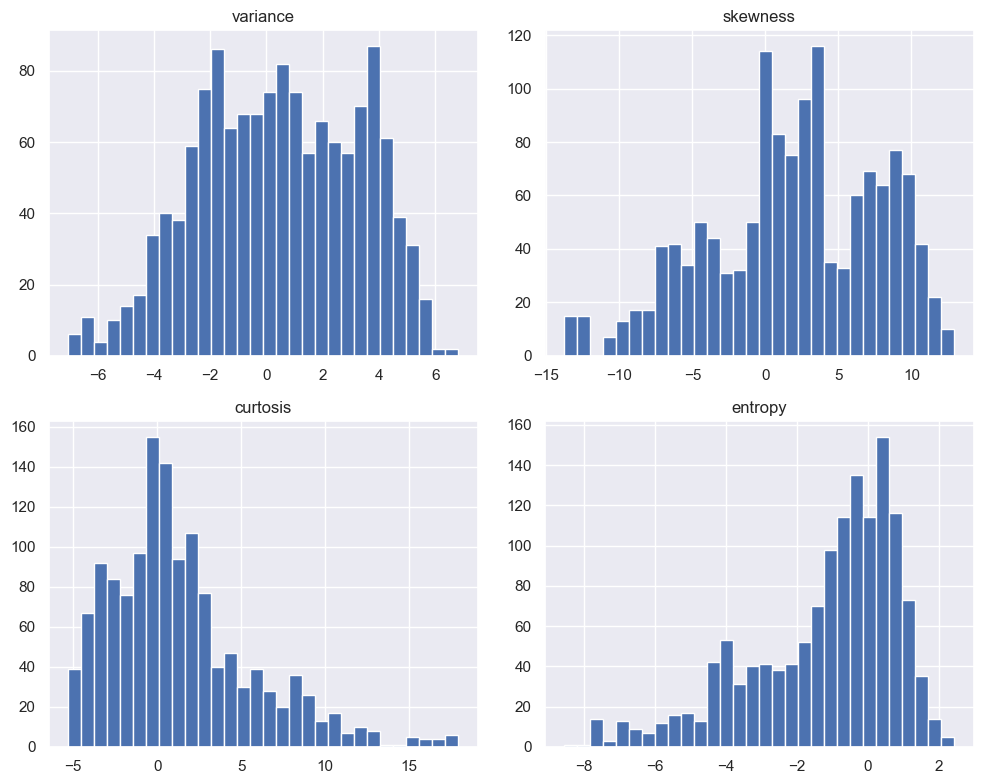

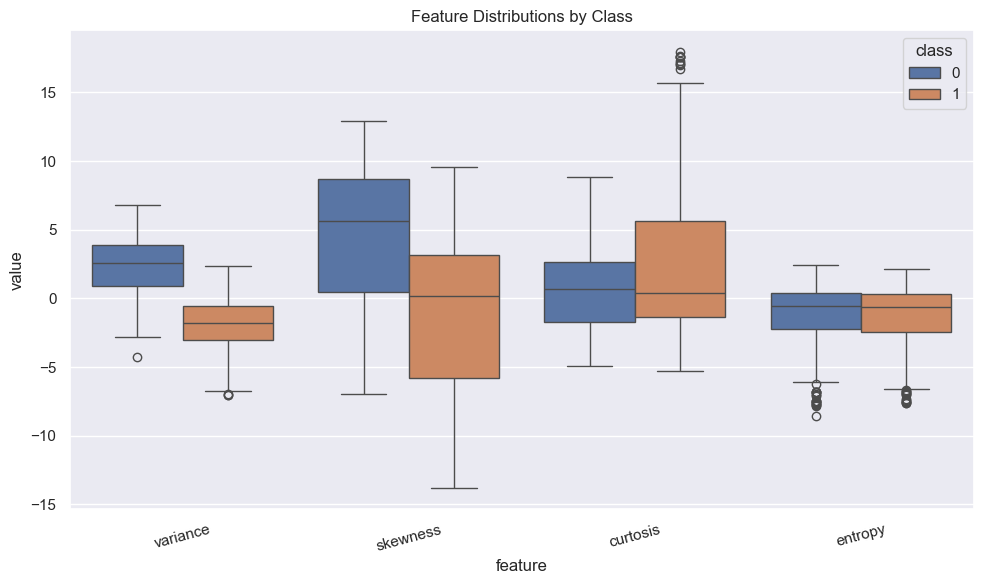

,count
class,
0,762
1,610


In [5]:
# 2.1 Distributions
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, col in zip(axes.ravel(), ["variance","skewness","curtosis","entropy"]):
    ax.hist(df[col], bins=30)
    ax.set_title(col)
plt.tight_layout()
plt.show()

# Boxplots by class
plt.figure(figsize=(10,6))
sns.boxplot(data=df.melt(id_vars="class", var_name="feature", value_name="value"),
            x="feature", y="value", hue="class")
plt.title("Feature Distributions by Class")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Class balance
df['class'].value_counts().to_frame("count")


In [7]:
# 2.2 Missing / cleaning (this dataset normally has none)
assert df.isna().sum().sum() == 0, "Unexpected missing values"

# 2.3 Feature list (numeric), scaling will be handled in pipeline
features = ["variance","skewness","curtosis","entropy"]
target = "class"


## 3. Feature Selection and Justification

**3.1** Choose features (X) and target (y).  
**3.2** Define `X` and `y`.

**Justification.** All four numeric features are derived from image statistics and are known to be predictive for this task.  
**Reflection 3.** Why these features? Expected impact on predictions?


In [8]:
X = df[features].copy()
y = df[target].copy()

X.sample(5, random_state=42), y.value_counts()


(     variance  skewness  curtosis  entropy
 430  1.569100    6.3465   -0.1828  -2.4099
 588 -0.278020    8.1881   -3.1338  -2.5276
 296  0.051979    7.0521   -2.0541  -3.1508
 184 -1.755900   11.9459    3.0946  -4.8978
 244  2.428700    9.3821   -3.2477  -1.4543,
 class
 0    762
 1    610
 Name: count, dtype: int64)

## 4. Train a Model (Baseline: Logistic Regression)

**4.1** Train/test split (stratified).  
**4.2** Train with `LogisticRegression` in a pipeline (with scaling).  
**4.3** Evaluate: Accuracy, Precision, Recall, F1 + Confusion Matrix + ROC.

**Reflection 4.** How well did baseline perform? Any surprises?


In [9]:
# 4.1 Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# 4.2 Pipeline with scaling
num_proc = ColumnTransformer(
    transformers=[("num", StandardScaler(), features)],
    remainder="drop"
)

logreg_clf = Pipeline(steps=[
    ("prep", num_proc),
    ("model", LogisticRegression(max_iter=500, n_jobs=None))
])

logreg_clf.fit(X_train, y_train)

# 4.3 Metrics
y_pred = logreg_clf.predict(X_test)
y_proba = logreg_clf.predict_proba(X_test)[:,1]

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred)
}
metrics


{'accuracy': 0.9737609329446064,
 'precision': 0.9440993788819876,
 'recall': 1.0,
 'f1': 0.9712460063897763}

Classification report (LogReg):
              precision    recall  f1-score   support

           0      1.000     0.953     0.976       191
           1      0.944     1.000     0.971       152

    accuracy                          0.974       343
   macro avg      0.972     0.976     0.974       343
weighted avg      0.975     0.974     0.974       343



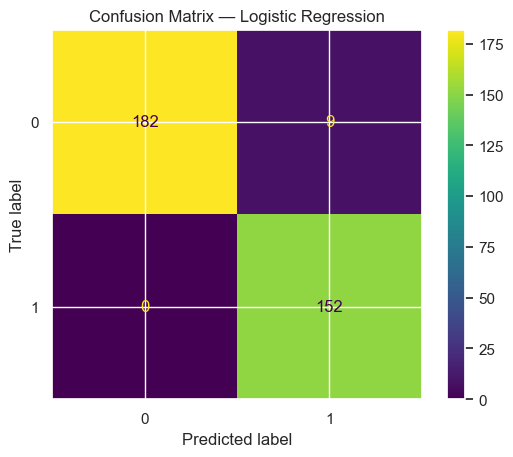

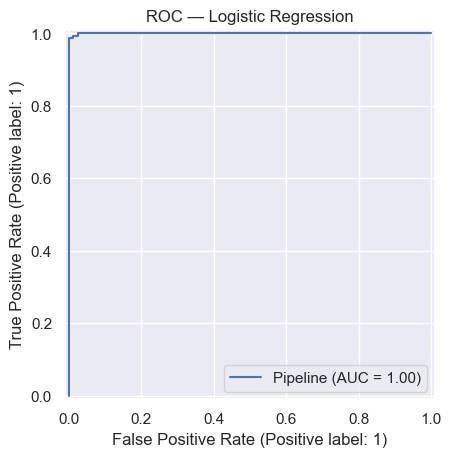

In [10]:
print("Classification report (LogReg):")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix — Logistic Regression")
plt.show()

RocCurveDisplay.from_estimator(logreg_clf, X_test, y_test)
plt.title("ROC — Logistic Regression")
plt.show()


## 5. Improve the Model or Try Alternatives

**5.1** Train alternate classifiers (Decision Tree, Random Forest) with simple tuning.  
**5.2** Compare performance across the same metrics.

**Reflection 5.** Which model performed best and why might that be?


In [11]:
# Decision Tree (no scaling required, but keep consistent pipeline)
tree_clf = Pipeline(steps=[
    ("prep", "passthrough"),  # raw features OK for trees
    ("model", DecisionTreeClassifier(random_state=42, max_depth=None, min_samples_split=2))
])
tree_clf.fit(X_train, y_train)
tree_pred = tree_clf.predict(X_test)

# Random Forest (strong baseline on tabular)
rf_clf = Pipeline(steps=[
    ("prep", "passthrough"),
    ("model", RandomForestClassifier(
        n_estimators=300, max_depth=None, random_state=42, n_jobs=-1
    ))
])
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

def summarize(name, y_true, y_hat, est=None, Xte=None):
    out = {
        "model": name,
        "accuracy": accuracy_score(y_true, y_hat),
        "precision": precision_score(y_true, y_hat),
        "recall": recall_score(y_true, y_hat),
        "f1": f1_score(y_true, y_hat),
    }
    return out

summary = []
summary.append(summarize("LogReg", y_test, y_pred, logreg_clf, X_test))
summary.append(summarize("DecisionTree", y_test, tree_pred, tree_clf, X_test))
summary.append(summarize("RandomForest", y_test, rf_pred, rf_clf, X_test))
pd.DataFrame(summary).sort_values("f1", ascending=False)


,model,accuracy,precision,recall,f1
2,RandomForest,0.994169,0.987013,1.000000,0.993464
1,DecisionTree,0.985423,0.974194,0.993421,0.983713
0,LogReg,0.973761,0.944099,1.000000,0.971246


<Figure size 600x500 with 0 Axes>

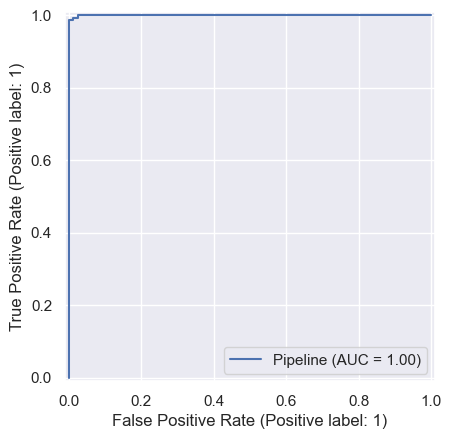

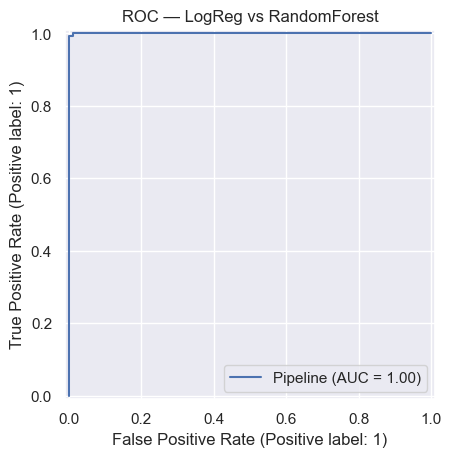

In [12]:
# Optional: ROC curves comparison (needs predict_proba)
plt.figure(figsize=(6,5))
RocCurveDisplay.from_estimator(logreg_clf, X_test, y_test)
RocCurveDisplay.from_estimator(rf_clf, X_test, y_test)
plt.title("ROC — LogReg vs RandomForest")
plt.show()


In [13]:
# Optional: Feature importances for RF
rf_model = rf_clf.named_steps["model"]
fi = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)
fi


variance    0.555975
skewness    0.241091
curtosis    0.148317
entropy     0.054617
dtype: float64

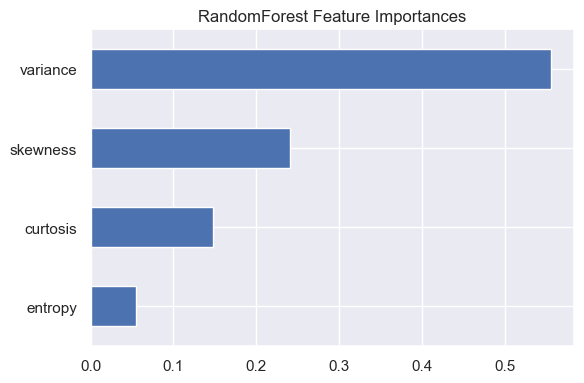

In [14]:
plt.figure(figsize=(6,4))
fi.sort_values().plot(kind="barh")
plt.title("RandomForest Feature Importances")
plt.tight_layout()
plt.show()


## 6. Final Thoughts & Insights

**6.1** Summarize the findings (best model + key metrics).  
**6.2** Challenges faced.  
**6.3** What to try next (e.g., cross-validation, hyperparameter tuning grid, calibration).

**Reflection 6.** What did you learn from this project?
